In [1]:
import numpy as np
import pandas as pd
from pandas import json_normalize
import seaborn as sns
import matplotlib.pyplot as plt

import time
import datetime
import ast

import json
import os
from dotenv import load_dotenv #pip install python-dotenv

from bs4 import BeautifulSoup
import requests 

from selenium import webdriver 
from selenium.webdriver.common.keys import Keys 
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

import warnings
warnings.filterwarnings("ignore")

from my_functions import *

In [12]:
# comprovar quantes requests he fet i quantes me'n queden

url_search = "https://api.discogs.com/database/search"

params = {
    "type": "release"  # Search for masters
    , "format": "album"           # just search for albums
    , "per_page": 100    # Number of results per page (max 100)
    , "page": 1          # Start with page 1
    , 'country': 'UK'
    , "year": 2015
    , 'genre': 'Rock'
    # , "style": style
}

headers = {"User-Agent": "MyDiscogsApp/1.0", "Authorization": "Discogs token=UwfqmsztxwnfABgQpmhaAsprbUgpOJKGOJSQAqfp"}
response = requests.get(url_search, headers=headers, params=params)

rate_limit = response.headers.get("X-Discogs-Ratelimit")
rate_limit_used = response.headers.get("X-Discogs-Ratelimit-Used")
rate_limit_remaining = response.headers.get("X-Discogs-Ratelimit-Remaining")

print(f"Rate Limit: {rate_limit}")
print(f"Rate Limit Used: {rate_limit_used}")
print(f"Rate Limit Remaining: {rate_limit_remaining}")

Rate Limit: 60
Rate Limit Used: 0
Rate Limit Remaining: 60


### **Proves**: un any en un país

In [32]:
# get all rock_styles in one year in one country

url = "https://api.discogs.com/database/search"
headers = {"User-Agent": 'Arnau', "Authorization": "Discogs token=UwfqmsztxwnfABgQpmhaAsprbUgpOJKGOJSQAqfp"}

# genres = ["Blues", "Classical", "Electronic", "Folk, World, & Country", "Funk / Soul", "Hip-Hop", "Jazz", "Latin", "Pop", "Rock", "Stage & Screen"]
# rock_styles = ["Pop Rock", "Punk", "Alternative Rock", "Indie Rock", "Hardcore", "Rock & Roll", "Hard Rock", "Psychedelic Rock"
#               , "Black Metal", "Heavy Metal", "Folk Rock", "Experimental", "Prog Rock", "Death Metal", "Garage Rock"]

for year in range(1985, 1995):
    # Define parameters for artist search
    params = {
        "per_page": 100    # Number of results per page (max 100)
        , 'type': 'release'
        , 'format': 'album'
        , 'genre': 'Rock'

        # items to change
        , 'country': 'US'
        , 'year': year
        # , 'style': style
    }

    response = requests.get(url, headers=headers, params=params)
    data = response.json()
    items_number = data['pagination']['items']  # number of items

    print(f"{year}: {items_number}")

1985: 5468
1986: 6707
1987: 7876
1988: 8319
1989: 8456
1990: 8084
1991: 7329
1992: 7487
1993: 7920
1994: 9947


In [31]:
# get one style in one year in one country

url = "https://api.discogs.com/database/search"
headers = {"User-Agent": "MyDiscogsApp/1.0", "Authorization": "Discogs token=UwfqmsztxwnfABgQpmhaAsprbUgpOJKGOJSQAqfp"}

# Define parameters for artist search
params = {
    "per_page": 100    # Number of results per page (max 100)
    , 'type': 'release'
    , 'format': 'album'
    , 'page': 1

    # items to change
    , 'country': 'US'
    , 'year': 1968
    , 'genre': 'Rock'
    # , 'style': 'Prog Rock'
}

response = requests.get(url, headers=headers, params=params)
data = response.json()
items_number = response.json()['pagination']['items']  # number of items

print(f"Items: {items_number}")

# response.json()

Items: 4331


### Chat-GPT all albums, including where ``master_id = 0``

In [ ]:
import requests
import time
import pandas as pd
import numpy as np

url_search = "https://api.discogs.com/database/search"
headers = {"User-Agent": "MyDiscogsApp", "Authorization": "Discogs token=UwfqmsztxwnfABgQpmhaAsprbUgpOJKGOJSQAqfp"}

df_masters_scraped = pd.read_csv('Datasets/df_masters.csv')

# Crear listas vacías
artist_id_list, artists_list, titles_list, years_list, release_countries_list = [], [], [], [], []
album_length_list, tracks_list, release_type_list, genres_list, styles_list = [], [], [], [], []
master_id_new_list, artist_profile_list, main_release_id_list = [], [], []

attempts, scraped = 0, 0
start_year = 1962

def scrape_album_data(url, is_master):
    """Obtiene la información de un álbum o master desde Discogs."""
    response = requests.get(url, headers=headers)
    time.sleep(1)
    data = response.json()

    artist = data['artists'][0]['name']
    if artist == 'Various':
        return None  # No quiero recopilatorios
    
    title = data['title']
    release_year = data['year']
    genres = data.get('genres', [])
    styles = data.get('styles', [])
    
    # Calcular la duración total del álbum
    number_of_songs = len(data.get('tracklist', []))
    song_durations = []
    
    for song in data.get('tracklist', []):
        song_duration = song.get('duration', '')
        try:
            minutes, seconds = map(int, song_duration.split(':'))
            song_durations.append(minutes + seconds / 60)
        except:
            pass
    
    album_length = round(sum(song_durations), 2)
    artist_id = data['artists'][0]['id']
    
    if is_master:
        main_release_id = data['main_release']
        release_url = f"https://api.discogs.com/releases/{main_release_id}"
    else:
        main_release_id = data['id']
        release_url = url
    
    # Obtener país y formato de la edición principal
    response = requests.get(release_url, headers=headers)
    time.sleep(1)
    release_data = response.json()
    
    release_country = release_data.get('country', 'Unknown')
    release_type = release_data.get('formats', [{}])[0].get('descriptions', ['Unknown'])
    
    # Obtener información del artista
    artist_url = f"https://api.discogs.com/artists/{artist_id}"
    response = requests.get(artist_url, headers=headers)
    time.sleep(1)
    artist_data = response.json()
    
    artist_profile = artist_data.get('profile', np.nan)
    
    return {
        "artist_id": str(artist_id),
        "artist": artist,
        "title": title,
        "release_year": release_year,
        "genres": genres,
        "styles": styles,
        "master_id": data.get('id') if is_master else np.nan,
        "album_length": album_length,
        "tracks": number_of_songs,
        "release_country": release_country,
        "release_type": release_type,
        "artist_profile": artist_profile,
        "main_release_id": main_release_id
    }

for year in range(start_year, start_year-3, -1):
    print(f'Year: {year}')

    params = {
        "type": "release",
        "format": "album",
        "per_page": 100,
        "page": 1,
        "country": "UK",
        "year": year,
        "genre": "Rock"
    }

    response1 = requests.get(url_search, headers=headers, params=params)
    time.sleep(1)
    data1 = response1.json()

    items = data1['pagination']['items']
    print(f'Items: {items} releases')

    pages = data1['pagination']['pages'] + 1

    for page in range(1, pages):
        print(f'------------ Page: {page} of {pages-1}, {year} -------------')

        params['page'] = page
        response2 = requests.get(url_search, headers=headers, params=params)
        time.sleep(1)
        data2 = response2.json()

        for result in data2['results']:
            try:
                attempts += 1
                time.sleep(1)

                master_id = result.get('master_id', 0)
                release_id = result['id']

                # Si master_id == 0, usa release_id, de lo contrario, usa master_id
                if master_id == 0:
                    url = f"https://api.discogs.com/releases/{release_id}"
                else:
                    if master_id in master_id_new_list or master_id in df_masters_scraped['master_id'].values:
                        print(f'{attempts} attempts - {scraped} scraped - master_id {master_id} already scraped')
                        continue
                    url = f"https://api.discogs.com/masters/{master_id}"
                
                album_data = scrape_album_data(url, is_master=(master_id != 0))
                
                if album_data:
                    artist_id_list.append(album_data["artist_id"])
                    artists_list.append(album_data["artist"])
                    titles_list.append(album_data["title"])
                    years_list.append(album_data["release_year"])
                    genres_list.append(album_data["genres"])
                    styles_list.append(album_data["styles"])
                    master_id_new_list.append(album_data["master_id"])
                    album_length_list.append(album_data["album_length"])
                    tracks_list.append(album_data["tracks"])
                    release_countries_list.append(album_data["release_country"])
                    release_type_list.append(album_data["release_type"])
                    artist_profile_list.append(album_data["artist_profile"])
                    main_release_id_list.append(album_data["main_release_id"])
                    
                    scraped += 1

                    print(f'{attempts} attempts - {scraped} scraped - {album_data["artist"]} - {album_data["title"]}')
                
            except Exception as e:
                print(f'Error en {release_id}: {e}')
                continue


Year: 1962
Items: 104 releases
------------ Page: 1 of 2, 1962 -------------
1 attempts - 1 scrapped - Joey Dee & The Starliters - Back At The Peppermint Lounge / Twistin'
2 attempts - 1 scrapped - master_id 701508 already scrapped
3 attempts - 2 scrapped - Sandy Nelson - Teenage House Party
4 attempts - 3 scrapped - Chubby Checker - Twist-A-Long With Chubby Checker
5 attempts - 3 scrapped - master_id 340807 already scrapped
6 attempts - 4 scrapped - Sandy Nelson - Drummin' Up A Storm
7 attempts - 5 scrapped - Gary U.S. Bonds - Twist Up Calypso
8 attempts - 5 scrapped - master_id 573548 already scrapped
9 attempts - 5 scrapped - master_id 459934 already scrapped
10 attempts - 5 scrapped - master_id 393302 already scrapped
11 attempts - 5 scrapped - master_id 391578 already scrapped
12 attempts - 5 scrapped - master_id 459934 already scrapped
13 attempts - 5 scrapped - master_id 459934 already scrapped
14 attempts - 6 scrapped - The Champs - Great Dance Hits
15 attempts - 6 scrapped - m

In [249]:
minutes = 12
attempts = 271

seconds_per_attempt = minutes*60/attempts
seconds_per_attempt 

2.6568265682656826

### **defining the function to get all albums**, including where ``master_id = 0``

In [7]:
def get_masters_us(start_year, final_year, step):
    url_search = "https://api.discogs.com/database/search"
    headers = {"User-Agent": "MyDiscogsApp", "Authorization": "Discogs token=UwfqmsztxwnfABgQpmhaAsprbUgpOJKGOJSQAqfp"}

    # import the df that contains all the albums already scraped (mosty from the UK)
    df_masters_scraped = pd.read_csv('Datasets/df_masters.csv')

    # import the df that contains all the albums already scraped and cleaned (mosty from the UK)
    df_uk_rock = pd.read_csv('Datasets/df_uk_rock.csv')

    # import the df of the albums from the US scraped so far (from 1960)
    df_us_masters_scraped = pd.read_csv('Datasets/df_us_masters.csv')

    # explode 'styles'
    df_us_masters_scraped['styles']=df_us_masters_scraped["styles"].apply(ast.literal_eval)
    df_styles = df_us_masters_scraped.explode('styles')
    top_80_styles = df_styles['styles'].value_counts().head(80).index.to_list()

    # create empty lists
    artist_id_list = []
    artists_list = []
    titles_list = []
    years_list = []
    release_countries_list = []
    album_length_list = []
    tracks_list = []
    release_type_list = []
    genres_list = []
    styles_list = []
    master_id_new_list = []
    artist_profile_list = []
    main_release_id_list = []

    attempts = 0
    scraped = 0

    for year in range(start_year, final_year, step):
        for style in top_80_styles:
            print(f'{style} releases of {year}')

            # Define parameters for album search
            params = {
                "type": "release"  # Search for masters
                , "format": "album"           # just search for albums
                , "per_page": 100    # Number of results per page (max 100)
                , "page": 1          # Start with page 1
                , 'country': 'US'
                , "year": year
                , 'genre': 'Rock'
                , 'style': style
            }

            response1 = requests.get(url_search, headers=headers, params=params)
            time.sleep(1)
            data1 = response1.json()

            items = data1['pagination']['items']
            print(f'Items: {items} {style} releases')

            pages = data1['pagination']['pages']+1
            
            for page in range(1, pages):
                print(f'------------ Page: {page} of {pages-1}, {style} of {year} -------------')

                params['page'] = page     # change pages
                response2 = requests.get(url_search, headers=headers, params=params)
                data2 = response2.json()

                for id in range(len(data2['results'])):
                    try:
                        attempts+=1
                        time.sleep(1)
                        master_id = data2['results'][id]['master_id']
                        release_id = data2['results'][id]['id']

                        if master_id == 0:
                            print(f'{attempts} attempts - {scraped} scraped - {((page-1)*100)+id+1}/{items} - master_id {master_id}')

                            url_release = f"https://api.discogs.com/releases/{release_id}"
                            response3 = requests.get(url_release, headers=headers)
                            # time.sleep(1)
                            data3 = response3.json()
                            artist = data3['artists'][0]['name']
                            title = data3['title']

                            if ((df_masters_scraped['artist'] == artist) & (df_masters_scraped['title'] == title)).any() or \
                                ((df_us_masters_scraped['artist'] == artist) & (df_us_masters_scraped['title'] == title)).any() or \
                                ((df_uk_rock['artist'] == artist) & (df_uk_rock['title'] == title)).any():
                                print(f"Album already scraped: {artist} - {title}")
                                continue

                            elif (artist, title) in zip(artists_list, titles_list):
                                print(f"Album already scraped right now: {artist} - {title}") 
                                continue        

                            else:
                                try:
                                    if artist == 'Various':
                                            print(f'{attempts} attempts - {scraped} scraped - {((page-1)*100)+id+1}/{items} - release_id {release_id}: Compilation') 
                                            continue   # I don't want compilations
                                    else:
                                    # define the data I want to get
                                        release_year = data3['year']                
                                        genres = data3['genres']
                                        styles = data3['styles']
                                        if 'Rock' not in genres:
                                            print('Not a rock album. Skipping')
                                            continue    # I only want rock albums

                                    # a more complex information is the total duration of the album, I have to sum the durations of each song
                                        number_of_songs = len(data3['tracklist'])
                                        song_durations = []

                                        for song in range(number_of_songs):
                                            song_duration = data3['tracklist'][song]['duration']
                                            try:
                                                minutes, seconds = map(int, song_duration.split(':'))
                                                song_duration_minutes = minutes + seconds/60
                                                song_durations.append(song_duration_minutes)
                                            except:
                                                pass
                                            album_length = round(sum(song_durations), 2)

                                        artist_id = data3['artists'][0]['id']

                                    # define the data I want to get
                                        release_country = data3['country']
                                        release_type = data3['formats'][0]['descriptions']
                                        if 'Compilation' in release_type:
                                            print('Compilation detected. Skipping')
                                            continue    # pass to the next album, I don't want compilations

                                    # artist page
                                        url = f"https://api.discogs.com/artists/{artist_id}"
                                        time.sleep(1)
                                        response5 = requests.get(url, headers=headers)
                                        data5 = response5.json()

                                    # define the data I want to get
                                        try:
                                            artist_profile = data5['profile']
                                        except:
                                            artist_profile = np.nan
                                            pass

                                    # save the info in the lists
                                        artist_id_list.append(str(artist_id))
                                        artists_list.append(artist)
                                        titles_list.append(title)
                                        years_list.append(release_year)
                                        genres_list.append(genres)
                                        styles_list.append(styles)
                                        master_id_new_list.append(0)
                                        album_length_list.append(album_length)
                                        tracks_list.append(number_of_songs)
                                        release_countries_list.append(release_country)
                                        release_type_list.append(release_type)
                                        main_release_id_list.append(release_id)

                                        if artist_profile == '':
                                            artist_profile_list.append(np.nan)
                                        else:
                                            artist_profile_list.append(artist_profile)

                                        scraped+=1

                                    # list lengths
                                        lists = [artist_id_list, main_release_id_list, master_id_new_list, release_countries_list, artists_list, titles_list, album_length_list
                                                , tracks_list, release_type_list, genres_list, styles_list, artist_profile_list, years_list]

                                    # Check if all lists have the same length
                                        lengths = [len(lst) for lst in lists]
                                        if len(set(lengths)) != 1:
                                            print("Lengths are not the same.")
                                            break # stop the loop, I won't be able to store the data if I have one value missing

                                        print(f'{attempts} attempts - {scraped} scraped - {((page-1)*100)+id+1}/{items} - release_id {release_id}: {artist} - {title}')
                                except:
                                    print(f'{attempts} attempts - {scraped} scraped - {((page-1)*100)+id+1}/{items} - release_id {release_id}: {artist} - {title} - Album not found')
                                    continue    # sometimes it crashes for some unknown reason, so I skip this album and continue
                        
                        # if it's an album that I have already scraped in this current code
                        elif master_id in master_id_new_list:
                            print(f'{attempts} attempts - {scraped} scraped - {((page-1)*100)+id+1}/{items} - master_id {master_id} already in list') 
                            continue        # there are several releases of the same master_release, I just want one (the master_release)

                        elif (master_id in df_masters_scraped['master_id'].values) or \
                            (master_id in df_uk_rock['master_id'].values):
                            print(f'{attempts} attempts - {scraped} scraped - {((page-1)*100)+id+1}/{items} - master_id {master_id} already scraped from the UK')
                            continue        # I have already scraped it before

                        elif (master_id in df_us_masters_scraped['master_id'].values):
                            print(f'{attempts} attempts - {scraped} scraped - {((page-1)*100)+id+1}/{items} - master_id {master_id} already scraped from the USA')
                            continue        # I have already scraped it before

                        else:
                            url_master = f"https://api.discogs.com/masters/{master_id}"
                            response3 = requests.get(url_master, headers=headers)
                            time.sleep(1)
                            data3 = response3.json()

                            artist = data3['artists'][0]['name']

                            if artist == 'Various':
                                    print(f'{attempts} attempts - {scraped} scraped - {((page-1)*100)+id+1}/{items} - master_id {master_id}: Compilation') 
                                    continue   # I don't want compilations
                            else:
                            # define the data I want to get
                                title = data3['title']
                                release_year = data3['year']                 
                                genres = data3['genres']
                                styles = data3['styles']
                                if 'Rock' not in genres:
                                    print('Not a rock album. Skipping')
                                    continue    # I only want rock albums
                                
                            # a more complex information is the total duration of the album, I have to sum the durations of each song
                                number_of_songs = len(data3['tracklist'])
                                song_durations = []

                                for song in range(number_of_songs):
                                    song_duration = data3['tracklist'][song]['duration']
                                    try:
                                        minutes = int(song_duration.split(':')[0])
                                        seconds = int(song_duration.split(':')[1])
                                        song_duration_minutes = minutes + seconds/60
                                        song_durations.append(song_duration_minutes)
                                    except:
                                        pass
                                    album_length = round(sum(i for i in song_durations), 2)

                                main_release_id = data3['main_release']
                                artist_id = data3['artists'][0]['id']

                            # release page
                                url = f"https://api.discogs.com/releases/{main_release_id}"
                                # time.sleep(1)
                                response4 = requests.get(url, headers=headers)
                                data4 = response4.json()

                            # define the data I want to get
                                release_country = data4['country']
                                release_type = data4['formats'][0]['descriptions']
                                if 'Compilation' in release_type:
                                    print('Compilation detected. Skipping')
                                    continue    # pass to the next album, I don't want compilations

                            # artist page
                                url = f"https://api.discogs.com/artists/{artist_id}"
                                # time.sleep(1)
                                response5 = requests.get(url, headers=headers)
                                data5 = response5.json()

                            # define the data I want to get
                                try:
                                    artist_profile = data5['profile']
                                except:
                                    artist_profile = np.nan
                                    pass

                            # save the info in the lists
                                artist_id_list.append(str(artist_id))
                                artists_list.append(artist)
                                titles_list.append(title)
                                years_list.append(release_year)
                                genres_list.append(genres)
                                styles_list.append(styles)
                                master_id_new_list.append(master_id)
                                album_length_list.append(album_length)
                                tracks_list.append(number_of_songs)
                                release_countries_list.append(release_country)
                                release_type_list.append(release_type)
                                main_release_id_list.append(main_release_id)

                                if artist_profile == '':
                                    artist_profile_list.append(np.nan)
                                else:
                                    artist_profile_list.append(artist_profile)

                                scraped+=1

                            # list lengths
                                lists = [artist_id_list, main_release_id_list, master_id_new_list, release_countries_list, artists_list, titles_list, album_length_list
                                        , tracks_list, release_type_list, genres_list, styles_list, artist_profile_list, years_list]

                            # Check if all lists have the same length
                                lengths = [len(lst) for lst in lists]
                                if len(set(lengths)) != 1:
                                    print("Lengths are not the same.")
                                    break # stop the loop, I won't be able to store the data if I have one value missing

                                print(f'{attempts} attempts - {scraped} scraped - {((page-1)*100)+id+1}/{items} - master_id {master_id}: {artist} - {title}')
                                # time.sleep(1)

                            # save the data in a df and export it
                                data = pd.DataFrame({'artist_id': artist_id_list
                                , 'master_id': master_id_new_list
                                , 'main_release_id': main_release_id_list
                                , 'release_country': release_countries_list
                                , 'artist': artists_list
                                , 'title': titles_list
                                , 'year': years_list
                                , 'album_length': album_length_list
                                , 'tracks': tracks_list
                                , 'release_type': release_type_list
                                , 'genres': genres_list
                                , 'styles': styles_list
                                , 'artist_profile': artist_profile_list})

                    except:
                        print('Strange error')
                        continue    # sometimes it crashes for some unknown reason, so I skip this album and continue

        # export a df for every year
            data.to_csv(f'Datasets/df_us_{year}.csv', index=False)

### **Actual code to get all albums**

From 1995 there are more than 10.000 albums for each year, so I'd have to iterate over styles as well

In [4]:
# import the df of the albums from the US scraped so far (from 1960)
df_us_masters_scraped = pd.read_csv('Datasets/df_us_masters.csv')

# explode 'styles'
df_us_masters_scraped['styles']=df_us_masters_scraped["styles"].apply(ast.literal_eval)
df_styles = df_us_masters_scraped.explode('styles')
top_80_styles = df_styles['styles'].value_counts().head(80).index.to_list()
top_80_styles

['Pop Rock',
 'Alternative Rock',
 'Hard Rock',
 'Folk Rock',
 'Punk',
 'Psychedelic Rock',
 'Country Rock',
 'Indie Rock',
 'Rock & Roll',
 'Blues Rock',
 'Heavy Metal',
 'Soft Rock',
 'AOR',
 'Garage Rock',
 'Experimental',
 'Prog Rock',
 'New Wave',
 'Hardcore',
 'Folk',
 'Country',
 'Classic Rock',
 'Power Pop',
 'Thrash',
 'Gospel',
 'Soul',
 'Acoustic',
 'Vocal',
 'Avantgarde',
 'Ballad',
 'Southern Rock',
 'Synth-pop',
 'Art Rock',
 'Funk',
 'Jazz-Rock',
 'Rhythm & Blues',
 'Religious',
 'Lo-Fi',
 'Surf',
 'Lounge',
 'Rockabilly',
 'Fusion',
 'Glam',
 'Post-Punk',
 'Goth Rock',
 'Grunge',
 'Noise',
 'Disco',
 'Industrial',
 'Death Metal',
 'Arena Rock',
 'Soundtrack',
 'Easy Listening',
 'Beat',
 'Speed Metal',
 'Ska',
 'Ambient',
 'Doo Wop',
 'Funk Metal',
 'Jazz-Funk',
 'Parody',
 'New Age',
 'Ethereal',
 'Space Rock',
 'Acid Rock',
 'Psychedelic',
 'Free Improvisation',
 'Symphonic Rock',
 'Bluegrass',
 'Comedy',
 'Spoken Word',
 'Power Metal',
 'Instrumental',
 'Abstract',
 

In [9]:
# import the df of the albums from the US scraped so far (from 1960)
df_us_masters = pd.read_csv('Datasets/df_us_masters.csv')
df_us_masters.shape

(30585, 13)

<Axes: xlabel='count', ylabel='year'>

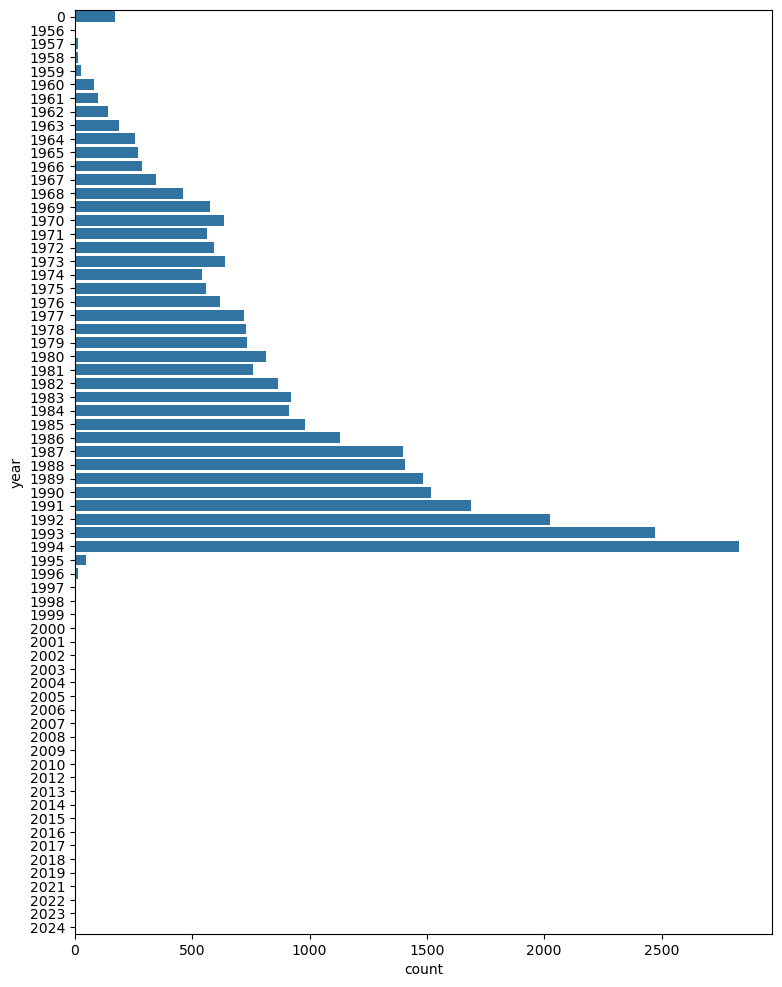

In [10]:
# make sure most of the albums are from the year I theoretically just got
plt.figure(figsize=(9,12))
sns.countplot(data=df_us_masters, y='year')

In [ ]:
get_masters_us(1998, 1999, 1)

In [36]:
minutes = 212
attempts = 8319 

seconds_per_attempt = minutes*60/attempts
seconds_per_attempt 

1.5290299314821494

Aprox 1.40 seconds per album

### **Importing the data**

Since the information in the lists exist only inside the function, I had to create the df and export it in order to save the information, so now I have to import it again.

In [65]:
data = pd.read_csv('Datasets/df_us_1992.csv')
print(f'Year: 1992 \n{data.shape[0]} releases\n{data.artist.nunique()} different artists\n')

Year: 1992 
6877 releases
5813 different artists



In [66]:
data.sample(5)

,artist_id,master_id,main_release_id,release_country,artist,title,year,album_length,tracks,release_type,genres,styles,artist_profile
3002,1353850.0,1596929,9376602,US,David Rodriguez (3),Man Against Beast,1990,0.00,15,['Album'],"['Rock', 'Blues', 'Folk, World, & Country']","['Acoustic', 'Folk', 'Texas Blues']",David was born on the 1st of January 1952 in H...
2771,362093.0,660265,3052011,US,Lizzy Borden,The Murderess Metal Road Show Live,1988,64.53,15,"['NTSC', 'Stereo']",['Rock'],['Heavy Metal'],Power metal/ Shock Rock band formed in 1983.\r...
4803,1424798.0,0,31175719,US,Boukman Eksperyans,Vodou Adjae,1991,58.93,11,"['Album', 'Unofficial Release']","['Rock', 'Latin', 'Funk / Soul', 'Folk, World,...",[],Boukman Eksperyans (English: Boukman Experienc...
5895,7996444.0,0,15579579,US,Terra (45),Terra,1992,0.00,10,['Album'],['Rock'],['Hard Rock'],NaN
2229,786396.0,126601,1401326,Europe,Token Entry,The Weight Of The World,1990,27.15,10,['Album'],['Rock'],"['Funk Metal', 'Hardcore', 'Punk']","Hardcore band from Queens, NYC formed in 1980 ..."


In [67]:
data.release_country.value_counts().head()

release_country
US         5909
Europe      298
Germany     158
Canada       89
UK           59
Name: count, dtype: int64

<Axes: xlabel='count', ylabel='year'>

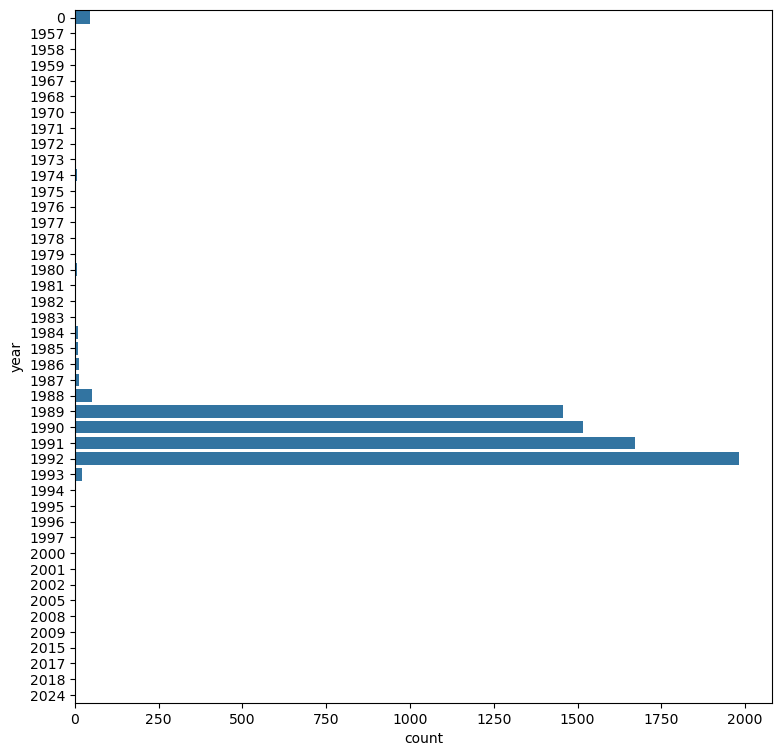

In [69]:
# make sure most of the albums are from the year I theoretically just got
plt.figure(figsize=(9,9))
sns.countplot(data=data, y='year')

### **Look for duplicates**

**Exact duplicates I can get rid of**

In [70]:
data[data.duplicated()].shape

(0, 13)

In [23]:
data.shape

(5071, 13)

In [24]:
data.drop_duplicates(inplace=True)
data.shape

(612, 13)

**Duplicates by some features, but not for ``master_id``, probably one ``master_id = 0``**

In [71]:
data.sort_values('master_id', inplace=True, ascending=False) # so I keep the master_id=0 at the end, these would be the duplicates and I'll be able to drop them
data.reset_index(drop=True, inplace=True)
data[data[['artist', 'title', 'year', 'album_length', 'tracks']].duplicated()].shape

(23, 13)

In [72]:
data[data[['artist', 'title', 'year', 'album_length', 'tracks']].duplicated()]

,artist_id,master_id,main_release_id,release_country,artist,title,year,album_length,tracks,release_type,genres,styles,artist_profile
4560,282556.0,0,16402161,US,Blasphemy (2),Fallen Angel Of Doom....,1990,30.15,10,['Album'],['Rock'],['Black Metal'],Canada's Blasphemy are part of the second wave...
4691,1801227.0,0,20719300,US,Late!,Pocketwatch,1992,34.68,10,['Album'],['Rock'],['Alternative Rock'],NaN
4772,179494.0,0,24533447,UK & Europe,Samhain,Final Descent,1990,33.55,11,['Album'],['Rock'],"['Goth Rock', 'Heavy Metal', 'Deathrock', 'Pun...","A death rock band from Lodi, New Jersey, forme..."
4793,1890056.0,0,12712574,US,Baton Rouge (3),Shake Your Soul,1990,42.30,12,['Album'],['Rock'],['Hard Rock'],American hard rock/hair metal band from Pearl ...
4831,50183.0,0,19672738,US,Ween,God Ween Satan - The Oneness,1990,71.15,26,['Album'],['Rock'],['Lo-Fi'],"Alternative rock duo from New Hope, PA, U.S.A...."
4886,83529.0,0,15755093,US,Guided By Voices,Propeller,1992,0.00,16,"['LP', 'Album', 'Limited Edition', 'Numbered',...",['Rock'],"['Indie Rock', 'Lo-Fi']",American alternative rock band formed in 1983 ...
5157,94849.0,0,29368909,US,Tempest (2),Serrated Edge,1992,42.38,10,['Album'],"['Electronic', 'Rock', 'Folk, World, & Country']","['Folk Rock', 'Celtic', 'Prog Rock']","Folk rock band from San Francisco, CA. Formed ..."
5209,259422.0,0,17232718,US,"""Weird Al"" Yankovic",Off The Deep End,1992,51.45,12,['Album'],"['Rock', 'Pop']","['Pop Rock', 'Parody']","""Weird Al"" Yankovic was born October 23, 1959 ..."
5367,129172.0,0,7402105,US,Poster Children,Flower Plower,1989,0.00,8,"['LP', 'Album']",['Rock'],"['Alternative Rock', 'Punk']",American indie rock band founded in 1987 in Ch...
5413,443813.0,0,6945411,US,Sweet Baby,It's A Girl,1989,0.00,13,"['LP', 'Album']",['Rock'],"['Punk', 'Pop Punk']","From Berkeley, California, USA."


In [73]:
data.shape

(6877, 13)

In [74]:
data.drop_duplicates(subset=(['artist', 'title', 'year', 'album_length', 'tracks']), inplace=True)
data.shape

(6854, 13)

In [21]:
data[data['title']=='Creation A Child']

,artist_id,master_id,main_release_id,release_country,artist,title,year,album_length,tracks,release_type,genres,styles,artist_profile
2536,2065456.0,296979,3035459,US,Corpus (7),Creation A Child,1973,38.83,9,"['LP', 'Album', 'Stereo']","['Rock', 'Blues']","['Psychedelic Rock', 'Blues Rock']","Blues-psych rock band from Corpus Christi, Texas."
5039,2065456.0,0,12241291,US,Corpus (7),Creation A Child,1973,38.83,9,"['LP', 'Album']","['Rock', 'Blues']","['Psychedelic Rock', 'Blues Rock']","Blues-psych rock band from Corpus Christi, Texas."


#### **Change the dtype of ``artist_id``** (if possible)

In [30]:
data[data['artist_id'].isna()]

,artist_id,master_id,main_release_id,release_country,artist,title,year,album_length,tracks,release_type,genres,styles,artist_profile
525,NaN,0,5312287,US,"Guess Who, The",Live At The Paramount,1972,46.02,7,"['Album', 'LP']",['Rock'],['Classic Rock'],NaN
547,NaN,0,6762254,US,Dave Lamb & Gye Whiz,I'll Be Alright,1971,32.35,8,"['LP', 'Album']",['Rock'],"['Folk Rock', 'Psychedelic Rock']",NaN


In [31]:
data[data['artist']=='Dave Lamb & Gye Whiz']

,artist_id,master_id,main_release_id,release_country,artist,title,year,album_length,tracks,release_type,genres,styles,artist_profile
547,NaN,0,6762254,US,Dave Lamb & Gye Whiz,I'll Be Alright,1971,32.35,8,"['LP', 'Album']",['Rock'],"['Folk Rock', 'Psychedelic Rock']",NaN


In [ ]:
data.loc[7046, 'artist_id'] = 32990

In [ ]:
data['artist_id'] = data['artist_id'].astype(int)
data.head()

### **Concat with the df that contains the albums previously scrapped**

In [75]:
# import the last df
df_masters = pd.read_csv('Datasets/df_us_masters.csv')
df_masters.shape

(18214, 13)

In [76]:
# concat with the df of the albums I just scraped
df_masters_concat = pd.concat([df_masters, data])
df_masters_concat.reset_index(drop=True, inplace=True)
df_masters_concat.shape

(25068, 13)

In [77]:
check_duplicates_albums(df_masters_concat)

Found 10 duplicates
Resulting dataset: (25058, 13)


In [78]:
print(f'{df_masters_concat.shape[0]} releases\n{df_masters_concat.artist.nunique()} different artists')

25058 releases
18089 different artists


### **Exporting to csv**

In [79]:
df_masters_concat.to_csv('Datasets/df_us_masters.csv', index=False)

### **Statistics**

In [80]:
# import the last df
df_masters = pd.read_csv('Datasets/df_us_masters.csv')
df_masters.shape

(25058, 13)

<Axes: xlabel='count', ylabel='year'>

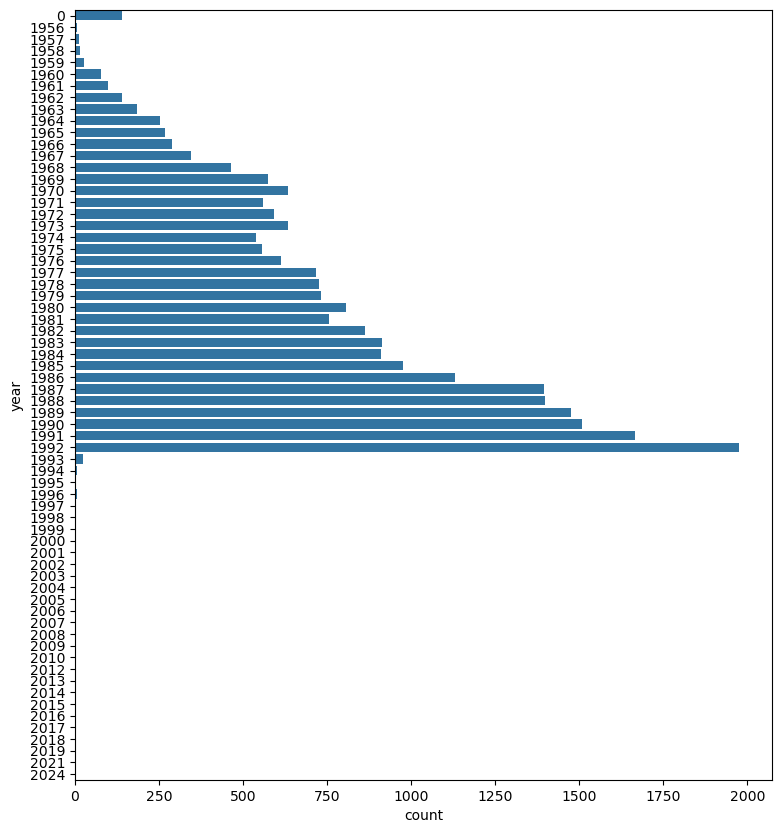

In [81]:
plt.figure(figsize=(9,10))
sns.countplot(data=df_masters, y='year')

In [82]:
df_masters.release_country.value_counts().head(10)

release_country
US             22432
Canada           513
Europe           468
Germany          369
UK               322
Netherlands      125
Australia        110
France            94
Mexico            69
Japan             59
Name: count, dtype: int64

In [83]:
df_masters.artist.value_counts().head(10)

artist
Eugene Chadbourne     48
Unknown Artist        44
The Rolling Stones    41
The Beatles           35
The Bunny Brains      33
Casey Kasem           22
R. Stevie Moore       22
Led Zeppelin          20
Elvis Presley         19
The Ventures          19
Name: count, dtype: int64

In [84]:
df_masters.genres.value_counts().head()

genres
['Rock']                              13658
['Rock', 'Folk, World, & Country']     2268
['Rock', 'Pop']                        2213
['Electronic', 'Rock']                  736
['Rock', 'Funk / Soul']                 624
Name: count, dtype: int64

In [85]:
df_masters.styles.value_counts().head(10)

styles
[]                      2969
['Pop Rock']             790
['Hard Rock']            659
['Alternative Rock']     566
['Heavy Metal']          464
['Punk']                 418
['Folk Rock']            412
['Country Rock']         372
['Psychedelic Rock']     302
['Indie Rock']           274
Name: count, dtype: int64

In [86]:
df_masters[df_masters['release_country']=='Europe'].sort_values('artist')

,artist_id,master_id,main_release_id,release_country,artist,title,year,album_length,tracks,release_type,genres,styles,artist_profile
20683,293116.0,383760,1950750,Europe,21 Guns,Salute,1992,50.82,12,['Album'],['Rock'],"['Hard Rock', 'Arena Rock', 'AOR']",21 Guns is a melodic hard rock band from Los A...
20572,155937.0,415194,3446518,Europe,220 Volt,Eye To Eye,1988,38.65,10,"['LP', 'Album', 'Stereo']",['Rock'],"['Hard Rock', 'Heavy Metal']","Swedish hard rock / metal band, formed in 1979..."
20302,966302.0,496822,3473810,Europe,9 Ways To Sunday,9 Ways To Sunday,1990,39.20,10,"['LP', 'Album', 'Stereo']","['Electronic', 'Rock']","['Alternative Rock', 'Synth-pop']",NaN
17548,255970.0,153008,1592271,Europe,Acrophet,Corrupt Minds,1988,33.80,13,"['LP', 'Album']",['Rock'],"['Thrash', 'Heavy Metal']",Acrophet was an American thrash metal band fro...
17655,32010.0,49513,1757319,Europe,Adele Bertei,Little Lives,1988,40.70,10,"['LP', 'Album']","['Rock', 'Pop']","['Pop Rock', 'Synth-pop']","Born in Cleveland, Ohio, has danced and brawle..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
21637,270530.0,163719,5857670,Europe,Wreck (2),Soul Train,0,0.00,15,['Album'],['Rock'],['Alternative Rock'],"Early 90s rock band from Chicago, IL which inc..."
21298,127769.0,251068,540176,Europe,Wrecking Crew,Balance Of Terror,1989,31.48,12,"['LP', 'Album']",['Rock'],"['Hardcore', 'Punk']",US-american Hardcore Punk band from Boston. Th...
12145,50263.0,35870,1751059,Europe,Yes,9012Live • The Solos,1985,34.40,7,"['LP', 'Album', 'Stereo']","['Rock', 'Stage & Screen']","['Soundtrack', 'Prog Rock']",Yes are an English rock band who achieved worl...
21929,387281.0,94268,551070,Europe,Zed Yago,Pilgrimage,1989,44.02,10,"['LP', 'Album']",['Rock'],['Heavy Metal'],German Heavy Metal band with female singers [a...


In [87]:
percentage_album_length_missing = round((df_masters['album_length']==0).sum() / df_masters.shape[0] * 100, 2)

print(f"albums missing album_length: {(df_masters['album_length']==0).sum()} ")
print(f'% missing album_length: {percentage_album_length_missing}%')

albums missing album_length: 9802 
% missing album_length: 39.12%


In [88]:
percentage_artist_profile_missing = round(df_masters['artist_profile'].isna().sum() / df_masters.shape[0] * 100, 2)

print(f"albums missing artist_profile: {df_masters['artist_profile'].isna().sum()} ")
print(f'% missing artist_profile: {percentage_artist_profile_missing}%')

albums missing artist_profile: 8039 
% missing artist_profile: 32.08%


In [89]:
df_masters[df_masters['artist_profile']==''] # should be empty

,artist_id,master_id,main_release_id,release_country,artist,title,year,album_length,tracks,release_type,genres,styles,artist_profile
